# Simple CNN model for MNIST, CIFAR-10, and CIFAR-100

In [1]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import copy
import time
import math
import random

# Machine learning imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, utils, datasets, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Other imports
from tqdm import tqdm

# Set seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
torch.cuda.manual_seed_all(42)

In [2]:
def set_device():
    ''' 
    Set device: either Cuda (GPU), MPS (Apple Silicon GPU), or CPU
    '''
    device = torch.device(
        "cuda"
        if torch.cuda.is_available()
        else "mps"
        if torch.backends.mps.is_available()
        else "cpu"
    )
    print(f"Using {device} device")
    return device

In [3]:
def data_loader(dataset: str, batch_size: int, image_size: int, data_use: int = 100, augment: bool = True):
    '''
    Function that takes in a dataset and returns train and test dataloaders along with the hyperparameters
    associated with the dataset.

    Parameters:
        dataset (str): Name of dataset to load. Options: MNIST, CIFAR10, CIFAR100
        batch_size (int): Batch size for dataloaders
        augment (bool): Whether to augment training data or not
        
    Returns:
        train_loader (DataLoader): Dataloader for training set
        val_loader (DataLoader): Dataloader for validation set
        test_loader (DataLoader): Dataloader for test set
        num_classes (int): Number of classes in dataset
        image_size (int): Size of image in dataset
        batch_size (int): Batch size for dataloaders
    '''

    base_train_transforms = [transforms.Resize((image_size, image_size)), transforms.ToTensor()]
    if dataset == "MNIST":
        base_train_transforms.append(transforms.Normalize((0.5,), (0.5,)))
    elif dataset == "CIFAR10":
        mean, std = (0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)
        base_train_transforms.append(transforms.Normalize(mean, std))
    elif dataset == "CIFAR100":
        mean, std = (0.5070, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762)
        base_train_transforms.append(transforms.Normalize(mean, std))

    # Additional augmentations for CIFAR10 and CIFAR100
    additional_transforms = []
    if augment:

        additional_transforms = [
            transforms.Resize((image_size, image_size)), # resizing capabilities if needed. Currently not used for our experiments
            transforms.RandomCrop(image_size, padding=4),
            transforms.RandomHorizontalFlip(), 
            transforms.RandomRotation(3.6),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.RandomAffine(degrees=0, scale=(0.8, 1.2)),
            transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
            transforms.Grayscale(num_output_channels=3),
            transforms.RandomSolarize(threshold=0.5, p=0.2),
        ]
    
    dataset_config = {
        'MNIST': {
            'dataset_cls': datasets.MNIST,
            'num_classes': 10,
            'default_image_size': 28,
            'batch_size': batch_size,  # Use the batch_size parameter
            'train_transform': transforms.Compose(base_train_transforms),
            'test_transform': transforms.Compose([
                transforms.Resize((image_size, image_size)),
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,))
            ])
        },
        'CIFAR10': {
            'dataset_cls': datasets.CIFAR10,
            'num_classes': 10,
            'default_image_size': 32,
            'batch_size': batch_size,
            'train_transform': transforms.Compose(additional_transforms + base_train_transforms),
            'test_transform': transforms.Compose([
                transforms.Resize((image_size, image_size)),
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
            ])
        },
        'CIFAR100': {
            'dataset_cls': datasets.CIFAR100,
            'num_classes': 100,
            'default_image_size': 32,
            'batch_size': batch_size,
            'train_transform': transforms.Compose(additional_transforms + base_train_transforms),
            'test_transform': transforms.Compose([
                transforms.Resize((image_size, image_size)),
                transforms.ToTensor(),
                transforms.Normalize((0.5070, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762))
            ])
        }
    }    

    # Ensure dataset is valid
    if dataset not in dataset_config:
        raise ValueError(f"Unsupported dataset: {dataset}. Supported datasets are: {', '.join(dataset_config.keys())}")

    # Access config
    cfg = dataset_config[dataset]

    # Print loading info
    print(f'Loading {dataset} dataset...')

    # Load data
    dataset_cls = cfg['dataset_cls']

    data_dir = '../data/'
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)

    train_dataset_full = dataset_cls(f'{data_dir}{dataset}_data/', train=True, download=True, transform=cfg['train_transform'])
    # decrease the amount of training data to data_use percentage
    train_dataset_full, _ = train_test_split(train_dataset_full, train_size=data_use/100, random_state=42, shuffle=True, stratify=train_dataset_full.targets)

    test_dataset = dataset_cls(f'{data_dir}{dataset}_data/', train=False, download=True, transform=cfg['test_transform'])
    # decrease the amount of test data to data_use value
    test_dataset, _ = train_test_split(test_dataset, train_size=data_use/100, random_state=42, shuffle=True, stratify=test_dataset.targets)

    # Split training dataset into training and validation sets
    train_size = int(0.8 * len(train_dataset_full))
    val_size = len(train_dataset_full) - train_size
    train_dataset, val_dataset = random_split(train_dataset_full, [train_size, val_size])

    # Compute optimal number of workers
    num_workers = min(4, os.cpu_count())

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=cfg['batch_size'], shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=cfg['batch_size'], shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(test_dataset, batch_size=cfg['batch_size'], shuffle=False, num_workers=num_workers)

    return train_loader, val_loader, test_loader, cfg['num_classes'], cfg['default_image_size']


In [4]:
class SimpleCNN(nn.Module):
    def __init__(self, dataset: str, drop: float):
        super(SimpleCNN, self).__init__()

        # Determine number of channels and classes based on the dataset
        in_channels = 1 if dataset == "MNIST" else 3
        num_classes = 100 if dataset == "CIFAR100" else 10

        # Pooling operation adjusted for dataset
        pool_kernel_size = 2
        pool_stride = 2  # Setting stride to 2 for both MNIST and CIFAR
        self.pool = nn.MaxPool2d(pool_kernel_size, pool_stride)

        if dataset == "MNIST":
            self.conv1 = nn.Conv2d(in_channels, 14, 3, padding=1)
            self.batch_norm1 = nn.BatchNorm2d(14)

            self.conv2 = nn.Conv2d(14, 28, 3, padding=1)
            self.batch_norm2 = nn.BatchNorm2d(28)

            self.conv3 = nn.Conv2d(28, 56, 3, padding=1)
            self.batch_norm3 = nn.BatchNorm2d(56)

            self.fc1 = nn.Linear(56 * 3 * 3, 512)

            self.dropout = nn.Dropout(drop)
            self.fc2 = nn.Linear(512, num_classes)
        else:
            self.conv1 = nn.Conv2d(in_channels, 16, 3, padding=1)
            self.batch_norm1 = nn.BatchNorm2d(16)

            self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
            self.batch_norm2 = nn.BatchNorm2d(32)

            self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
            self.batch_norm3 = nn.BatchNorm2d(64)

            self.fc1 = nn.Linear(64 * 4 * 4, 512)
            self.dropout = nn.Dropout(drop)
            self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        # Add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.batch_norm1(self.conv1(x))))
        x = self.pool(F.relu(self.batch_norm2(self.conv2(x))))
        x = self.pool(F.relu(self.batch_norm3(self.conv3(x))))

        # Flattening
        x = x.view(x.size(0), -1)

        # Add first hidden layer, with relu activation function
        x = F.relu(self.fc1(x))

        # Add dropout layer
        x = self.dropout(x)

        # Add second hidden layer, with relu activation function
        x = self.fc2(x)

        return x


In [5]:
mnist_model = SimpleCNN(dataset="MNIST", drop=0.01)

In [6]:
# Print model summary
summary(mnist_model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 14, 28, 28]             140
       BatchNorm2d-2           [-1, 14, 28, 28]              28
         MaxPool2d-3           [-1, 14, 14, 14]               0
            Conv2d-4           [-1, 28, 14, 14]           3,556
       BatchNorm2d-5           [-1, 28, 14, 14]              56
         MaxPool2d-6             [-1, 28, 7, 7]               0
            Conv2d-7             [-1, 56, 7, 7]          14,168
       BatchNorm2d-8             [-1, 56, 7, 7]             112
         MaxPool2d-9             [-1, 56, 3, 3]               0
           Linear-10                  [-1, 512]         258,560
          Dropout-11                  [-1, 512]               0
           Linear-12                   [-1, 10]           5,130
Total params: 281,750
Trainable params: 281,750
Non-trainable params: 0
-------------------------------

In [7]:
dataset = "CIFAR100" # <-- change this parameter only! Options: MNIST, CIFAR10, CIFAR100
data_use = 25 # <-- change this parameter for scaling dataset in percentage! Options: 25, 50, 75, 100
model_name = f"{dataset}_{data_use}_cnn_classifier"
image_size = 28 if dataset == "MNIST" else 32
learning_rate = 0.002
weight_decay = 0.0001
batch_size = 256
num_epochs = 50
patience_value = 10 if dataset == "MNIST" else 15 # default: 10 if not set
drop=0.01 # Adjust as necessary

In [8]:
# Send the models to the device
device = set_device()

# Initialise model
model = SimpleCNN(dataset, drop=drop)
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = ReduceLROnPlateau(optimizer, patience=patience_value, verbose=True)

# Load data
train_loader, val_loader, test_loader, num_classes, image_size = data_loader(dataset, batch_size, image_size=image_size, data_use=data_use, augment=False)


Using mps device
Loading CIFAR100 dataset...
Files already downloaded and verified
Files already downloaded and verified


In [9]:
# print length of train_dataset, val_dataset and test_dataset
print(f"Length of train_dataset: {len(train_loader.dataset)}")
print(f"Length of val_dataset: {len(val_loader.dataset)}")
print(f"Length of test_dataset: {len(test_loader.dataset)}")

Length of train_dataset: 10000
Length of val_dataset: 2500
Length of test_dataset: 2500


In [10]:
def train(model, train_loader, val_loader, criterion, optimizer, device, model_name,epochs=10, scheduler=None, patience=None):
    '''
    Function that trains the model.

    Parameters:
        model (nn.Module): Model to train
        train_loader (DataLoader): Dataloader for training set
        val_loader (DataLoader): Dataloader for validation set
        criterion (nn.Module): Loss function
        optimizer (nn.Module): Optimizer
        device (str): Device to use
        epochs (int): Number of epochs
        scheduler (nn.Module): Learning rate scheduler
        patience (int): Number of epochs to wait before early stopping
        model_name (str): Name of model

    Returns:
        model (nn.Module): Trained model
        train_losses (list): Training losses
        val_losses (list): Validation losses
        train_acc (list): Training accuracy
        val_acc (list): Validation accuracy
    '''
    
    # Set model to training mode
    model.train()

    # Initialize lists to store losses and accuracy
    train_losses = []
    val_losses = []
    train_acc = []
    val_acc = []
    best_val_loss = np.inf

    epochs_without_improvement = 0  # for early stopping

    # Record the start time for training
    start_time = time.time()

    for epoch in range(epochs):
        epoch_train_loss = 0
        epoch_train_acc = 0
        epoch_val_loss = 0
        epoch_val_acc = 0

        # Training
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs).to(device)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            epoch_train_acc += torch.sum(preds == labels.data)

        # Validation
        model.eval()  # <-- set model to eval mode for validation
        for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).to(device)
            loss = criterion(outputs, labels)
            epoch_val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            epoch_val_acc += torch.sum(preds == labels.data)
        model.train()  # <-- set model back to train mode

        # Average metrics
        epoch_train_loss /= len(train_loader.dataset)
        epoch_train_acc = epoch_train_acc.float() / len(train_loader.dataset)
        epoch_val_loss /= len(val_loader.dataset)
        epoch_val_acc = epoch_val_acc.float() / len(val_loader.dataset)

        if scheduler:
            scheduler.step(epoch_val_loss)

        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_without_improvement = 0  # reset the count
        else:
            epochs_without_improvement += 1

        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_acc.append(epoch_train_acc)
        val_acc.append(epoch_val_acc)

        print(f'Epoch {epoch+1}/{epochs} - '
              f'Train Loss: {epoch_train_loss:.4f}, '
              f'Train Acc: {epoch_train_acc:.4f}, '
              f'Val Loss: {epoch_val_loss:.4f}, '
              f'Val Acc: {epoch_val_acc:.4f}')

        # Early stopping
        if patience and epochs_without_improvement == patience:
            print("Early stopping due to no improvement in validation loss.")
            break

    # Record the end time for training
    end_time = time.time()
    # Calculate the total training time
    total_time_seconds = end_time - start_time
    if total_time_seconds < 60:
        print(f"Total training time: {total_time_seconds:.2f} seconds")
    else:
        total_time_minutes = total_time_seconds / 60
        print(f"Total training time: {total_time_minutes:.2f} minutes")
    
    model.load_state_dict(best_model_wts)
    # save trained model

    save_dir = '../trained_models/'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    torch.save(model.state_dict(), f'{save_dir}{model_name}.pth')

    return model, train_losses, val_losses, train_acc, val_acc

In [11]:
# train the model
model, train_losses, val_losses, train_acc, val_acc = train(model, train_loader, val_loader, criterion, optimizer, device, model_name, epochs=num_epochs, scheduler=scheduler, patience=patience_value)

Epoch 1/50 [Training]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/50 [Validation]: 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


Epoch 1/50 - Train Loss: 4.1821, Train Acc: 0.0669, Val Loss: 3.8778, Val Acc: 0.1028


Epoch 2/50 [Validation]: 100%|██████████| 10/10 [00:06<00:00,  1.57it/s]


Epoch 2/50 - Train Loss: 3.5781, Train Acc: 0.1486, Val Loss: 3.4995, Val Acc: 0.1576


Epoch 3/50 [Validation]: 100%|██████████| 10/10 [00:06<00:00,  1.57it/s]


Epoch 3/50 - Train Loss: 3.2368, Train Acc: 0.2076, Val Loss: 3.3741, Val Acc: 0.1932


Epoch 4/50 [Validation]: 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


Epoch 4/50 - Train Loss: 2.9862, Train Acc: 0.2521, Val Loss: 3.1982, Val Acc: 0.2224


Epoch 5/50 [Validation]: 100%|██████████| 10/10 [00:06<00:00,  1.57it/s]


Epoch 5/50 - Train Loss: 2.7429, Train Acc: 0.2987, Val Loss: 3.0835, Val Acc: 0.2432


Epoch 6/50 [Validation]: 100%|██████████| 10/10 [00:06<00:00,  1.57it/s]


Epoch 6/50 - Train Loss: 2.5067, Train Acc: 0.3459, Val Loss: 3.1337, Val Acc: 0.2440


Epoch 7/50 [Validation]: 100%|██████████| 10/10 [00:06<00:00,  1.57it/s]


Epoch 7/50 - Train Loss: 2.3270, Train Acc: 0.3917, Val Loss: 3.0766, Val Acc: 0.2664


Epoch 8/50 [Validation]: 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


Epoch 8/50 - Train Loss: 2.1576, Train Acc: 0.4241, Val Loss: 3.0965, Val Acc: 0.2668


Epoch 9/50 [Validation]: 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


Epoch 9/50 - Train Loss: 2.0019, Train Acc: 0.4575, Val Loss: 3.0606, Val Acc: 0.2800


Epoch 10/50 [Validation]: 100%|██████████| 10/10 [00:06<00:00,  1.58it/s]


Epoch 10/50 - Train Loss: 1.7896, Train Acc: 0.5100, Val Loss: 2.9942, Val Acc: 0.2992


Epoch 11/50 [Validation]: 100%|██████████| 10/10 [00:06<00:00,  1.58it/s]


Epoch 11/50 - Train Loss: 1.6473, Train Acc: 0.5424, Val Loss: 3.1148, Val Acc: 0.3016


Epoch 12/50 [Validation]: 100%|██████████| 10/10 [00:06<00:00,  1.57it/s]


Epoch 12/50 - Train Loss: 1.5197, Train Acc: 0.5788, Val Loss: 3.0758, Val Acc: 0.3036


Epoch 13/50 [Validation]: 100%|██████████| 10/10 [00:06<00:00,  1.57it/s]


Epoch 13/50 - Train Loss: 1.3276, Train Acc: 0.6310, Val Loss: 3.1138, Val Acc: 0.3004


Epoch 14/50 [Validation]: 100%|██████████| 10/10 [00:06<00:00,  1.56it/s]


Epoch 14/50 - Train Loss: 1.2396, Train Acc: 0.6542, Val Loss: 3.1075, Val Acc: 0.3148


Epoch 15/50 [Validation]: 100%|██████████| 10/10 [00:06<00:00,  1.56it/s]


Epoch 15/50 - Train Loss: 1.0984, Train Acc: 0.6889, Val Loss: 3.3532, Val Acc: 0.3068


Epoch 16/50 [Validation]: 100%|██████████| 10/10 [00:06<00:00,  1.57it/s]


Epoch 16/50 - Train Loss: 0.9569, Train Acc: 0.7289, Val Loss: 3.3518, Val Acc: 0.3116


Epoch 17/50 [Validation]: 100%|██████████| 10/10 [00:06<00:00,  1.57it/s]


Epoch 17/50 - Train Loss: 0.8323, Train Acc: 0.7672, Val Loss: 3.4630, Val Acc: 0.2936


Epoch 18/50 [Validation]: 100%|██████████| 10/10 [00:06<00:00,  1.56it/s]


Epoch 18/50 - Train Loss: 0.6922, Train Acc: 0.8076, Val Loss: 3.6067, Val Acc: 0.3008


Epoch 19/50 [Validation]: 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


Epoch 19/50 - Train Loss: 0.5848, Train Acc: 0.8430, Val Loss: 3.7773, Val Acc: 0.2884


Epoch 20/50 [Validation]: 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]


Epoch 20/50 - Train Loss: 0.6825, Train Acc: 0.8032, Val Loss: 3.8693, Val Acc: 0.2960


Epoch 21/50 [Validation]: 100%|██████████| 10/10 [00:06<00:00,  1.57it/s]


Epoch 21/50 - Train Loss: 0.4967, Train Acc: 0.8644, Val Loss: 3.8523, Val Acc: 0.2952


Epoch 22/50 [Validation]: 100%|██████████| 10/10 [00:06<00:00,  1.57it/s]


Epoch 22/50 - Train Loss: 0.4020, Train Acc: 0.8954, Val Loss: 3.9479, Val Acc: 0.3020


Epoch 23/50 [Validation]: 100%|██████████| 10/10 [00:06<00:00,  1.53it/s]


Epoch 23/50 - Train Loss: 0.3531, Train Acc: 0.9108, Val Loss: 3.9395, Val Acc: 0.2980


Epoch 24/50 [Validation]: 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]


Epoch 24/50 - Train Loss: 0.2777, Train Acc: 0.9340, Val Loss: 4.2515, Val Acc: 0.2968


Epoch 25/50 [Validation]: 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]

Epoch 25/50 - Train Loss: 0.3461, Train Acc: 0.9073, Val Loss: 4.2608, Val Acc: 0.2948
Early stopping due to no improvement in validation loss.
Total training time: 5.69 minutes


In [12]:
# create directory to save the plots
plot_dir = '../notebooks/plots/cnn/'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

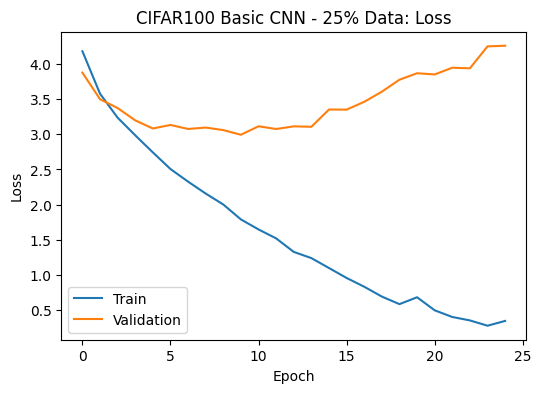

In [13]:
# Plot losses
plt.figure(figsize=(6, 4))
plt.title(f'{dataset} Basic CNN - {data_use}% Data: Loss')
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
# save the plot
plt.savefig(f'{plot_dir}{model_name}_basic_cnn_loss.pdf', format="pdf")
plt.show()

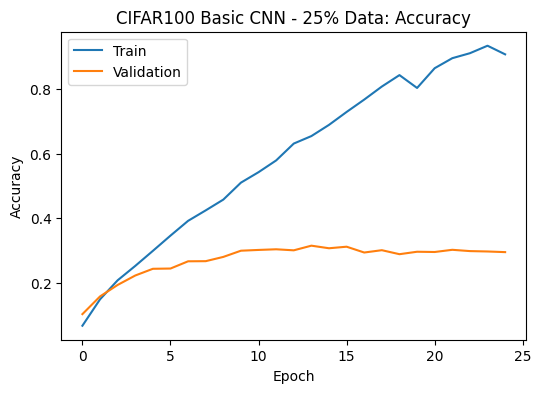

In [14]:
# Plot accuracies
plt.figure(figsize=(6, 4))
plt.title(f'{dataset} Basic CNN - {data_use}% Data: Accuracy')
# move list to cpu
train_acc = [i.cpu() for i in train_acc]
val_acc = [i.cpu() for i in val_acc]
plt.plot(train_acc, label='Train')
plt.plot(val_acc, label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
# save the plot
plt.savefig(f'{plot_dir}{model_name}_basic_cnn_acc.pdf', format="pdf")
plt.show()

In [15]:
# test on the test set

# Set model to eval mode
model.eval()

# Initialize lists to store predictions and labels
preds = []
labels = []

# Turn off gradients
with torch.no_grad():
    # Iterate over test data
    for batch_idx, (data, target) in tqdm(enumerate(test_loader), desc="Testing"):
        # Send data to device
        data, target = data.to(device), target.to(device)

        # Forward pass
        output = model(data)

        # Get predicted class
        pred = output.argmax(dim=1, keepdim=True)

        # Save predictions and labels for computing metrics later
        preds.extend(pred.cpu().numpy())
        labels.extend(target.cpu().numpy())

# Print accuracy
accuracy = accuracy_score(labels, preds)
print(f"Test accuracy: {accuracy:.4f}")


Testing: 10it [00:00, 22.57it/s]

Test accuracy: 0.3000


In [16]:
# Print classification report and confusion matrix
# Only print if dataset is not CIFAR100. CIFAR100 has too many classes to print
if dataset != "CIFAR100":
    # Print classification report
    print(classification_report(labels, preds))

    # Print confusion matrix
    cm = confusion_matrix(labels, preds)

    # Normalize the confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # Convert to percentages

    plt.figure(figsize=(6, 6))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{dataset} CNN - {data_use}% Data: Confusion Matrix (in %)')
    # save the plot
    plt.savefig(f'{plot_dir}{model_name}_cnn_cm.pdf', format="pdf")
    plt.show()